In [1]:
import math
import numpy as np
import os
import torch
from ldm.util import create_carvekit_interface, load_and_preprocess, instantiate_from_config
from PIL import Image, ImageDraw, ImageFont
from omegaconf import OmegaConf
from torchvision import transforms

/admin/home-dmitry/venvs/zero123_vanilla/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
def load_model_from_config(config, ckpt, vae_ckpt='', clip_ckpt='', verbose=False, min_step=0):
    print(f'Loading model from {ckpt}')
    pl_sd = torch.load(ckpt, map_location='cpu')
    sd = pl_sd['state_dict']
    global_step = 0
    if 'global_step' in pl_sd:
        global_step = pl_sd["global_step"]
        print(f'Global Step: {global_step}')
        if global_step < min_step:
            print("Skipping ckpt step ", global_step)
            return None, global_step
    model = instantiate_from_config(config.model)
    m, u = model.load_state_dict(sd, strict=False)
    if vae_ckpt:
        print(f'Loading VAE from {vae_ckpt}')
        model.first_stage_model.load_state_dict(torch.load(vae_ckpt))
    if clip_ckpt:
        print(f'Loading CLIP from {clip_ckpt}')
        model.cond_stage_model.load_state_dict(torch.load(clip_ckpt))

    model.cuda()
    model.eval()
    return model, global_step

In [62]:
# ckpt_path = '/fsx/proj-mod3d/dmitry/zero123logs/2023-10-18T13-13-54_latents_objaverse_elevcond_diffcolors/checkpoints/trainstep_checkpoints/epoch=002032-step=000249999.ckpt'
ckpt_path = '/fsx/proj-mod3d/dmitry/zero123logs/2023-08-02T21-12-36_latents_objaverse_polarcond/checkpoints/trainstep_checkpoints/epoch=002032-step=000244999.ckpt'
config_path = 'configs/sd-objaverse-finetune-c_concat-256.yaml'
config = OmegaConf.load(config_path)
model, global_step = load_model_from_config(
    config, ckpt_path,
    vae_ckpt='vae.ckpt', clip_ckpt='clip.ckpt',
    verbose=True, min_step=0)

Loading model from /fsx/proj-mod3d/dmitry/zero123logs/2023-08-02T21-12-36_latents_objaverse_polarcond/checkpoints/trainstep_checkpoints/epoch=002032-step=000244999.ckpt


Global Step: 245000
LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 859.53 M params.
Keeping EMAs of 688.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels
Loading VAE from vae.ckpt
Loading CLIP from clip.ckpt


In [6]:
img_size = 256
image_transforms = [transforms.Resize(img_size),
                    transforms.ToTensor(),
                    transforms.Lambda(lambda x: x * 2. - 1.)]
image_transforms = transforms.Compose(image_transforms)

In [102]:
n_frames = 21
azimuths = np.linspace(0, 2 * math.pi, n_frames)[1:]
azimuths

array([0.31415927, 0.62831853, 0.9424778 , 1.25663706, 1.57079633,
       1.88495559, 2.19911486, 2.51327412, 2.82743339, 3.14159265,
       3.45575192, 3.76991118, 4.08407045, 4.39822972, 4.71238898,
       5.02654825, 5.34070751, 5.65486678, 5.96902604, 6.28318531])

In [151]:
img = Image.open('/fsx/proj-mod3d/dmitry/repos/hard_examples_preprocessed/img/horse.png').convert("RGBA")
# img = Image.open('/fsx/proj-mod3d/dmitry/repos/rgba_0000.png').convert("RGBA")
background = Image.new('RGBA', img.size, (255, 255, 255))
img = Image.alpha_composite(background, img).convert("RGB")
img = image_transforms(img)

In [152]:
img_batch = img.unsqueeze(0).cuda().repeat_interleave(len(azimuths), 0)

In [153]:
elevation = 5
elevcond = math.radians(90 - elevation)
T_batch = torch.Tensor([
    [0, math.sin(az), math.cos(az), elevcond] for az in azimuths]).cuda()

In [154]:
novel_views = model.sample_novel_views(
    img_batch, T_batch, scales=[3.0], scale_cond=False, ddim_steps=50)

Scale factor: 0.18215


Data shape for DDIM sampling is (20, 4, 32, 32), eta 1.0
Running DDIM Sampling with 49 timesteps


DDIM Sampler: 100%|██████████| 49/49 [00:13<00:00,  3.65it/s]


In [155]:
novel_views = novel_views.squeeze(1)
novel_views = torch.stack([(img+1.0)/2.0] + list(novel_views))

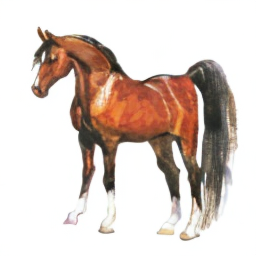

In [156]:
transforms.ToPILImage()(novel_views[1])

In [157]:
import cv2
from glob import glob
from einops import rearrange

save_path = 'test_orbits'
base_count = len(glob(os.path.join(save_path, "*.mp4")))
video_path = os.path.join(save_path, f"{base_count:06d}.mp4")
fps = 6

writer = cv2.VideoWriter(
    video_path,
    cv2.VideoWriter_fourcc(*"MP4V"),
    fps,
    (novel_views.shape[-1], novel_views.shape[-2]),
)

vid = (
    (rearrange(novel_views, "t c h w -> t h w c") * 255).cpu().numpy().astype(np.uint8)
)
for frame in vid:
    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
    writer.write(frame)

writer.release()

video_path_h264 = video_path[:-4] + "_h264.mp4"
os.system(f"ffmpeg -i {video_path} -c:v libx264 {video_path_h264}")

OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'
ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --e

0

: 